In [1]:
import torch

from IPython.display import HTML
from math import pi
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


sns.set_theme(context="talk", style="whitegrid")

# Fake (But Learnable) Data

(torch.Size([1000, 2]), torch.Size([1000]), torch.Size([1000]))

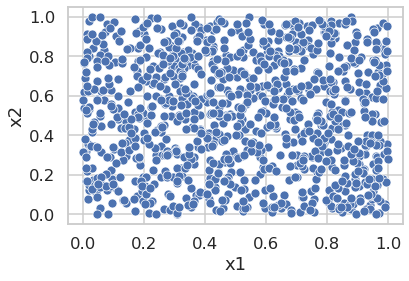

In [2]:
N = 1000

# Input with two features
nx = 2
X = torch.rand(N, nx)
x1 = X[:, 0]
x2 = X[:, 1]

df = pd.DataFrame({"x1": x1, "x2": x2})
ax = sns.scatterplot(data=df, x="x1", y="x2")

X.shape, x1.shape, x2.shape

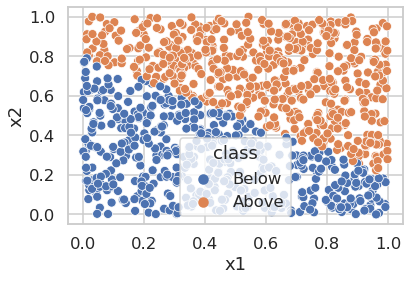

In [3]:
# Create a made-up classification for this data
# Example classification line (slope-intercept form):
#    y = -0.6x  + 0.8
#   x2 = -0.6x1 + 0.8
# Converted to standard form:
#   x2 + 0.6x1 - 0.8 = 0

Y = torch.zeros(N, 1)
Y[x2 + 0.6 * x1 - 0.8 > 0] = 1

classes = ["Above" if yi == 1 else "Below" for yi in Y]
df = pd.DataFrame({"x1": x1, "x2": x2, "class": classes})
ax = sns.scatterplot(data=df, x="x1", y="x2", hue="class")

In [4]:
N_valid = int(N * 0.2)
X_valid = X[:N_valid, :]
Y_valid = Y[:N_valid, :]

X_train = X[N_valid:, :]
Y_train = Y[N_valid:, :]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([800, 2]),
 torch.Size([800, 1]),
 torch.Size([200, 2]),
 torch.Size([200, 1]))

In [5]:
def bce_loss(Yhat, Y):
    return -(Y * torch.log(Yhat) + (1 - Y) * torch.log(1 - Yhat))

# Single Neuron

In [6]:
# Parameters
w = torch.randn(nx, 1)
b = torch.zeros(1)

ws = [w.clone()]
bs = [b.clone()]

# Hyper-parameters
learning_rate = 10
num_epochs = 100

# Formatting parameters
print_step = 5
prev_accuracy = 0

for epoch in range(num_epochs):

    # Forward propagation
    Yhat = torch.sigmoid(X_train @ w + b)

    # Backpropagation
    losses = bce_loss(Yhat, Y_train)
    loss = losses.mean()

    dZ = Yhat - Y_train
    dw = (1 / N) * dZ.T @ X_train
    db = dZ.mean()

    # Update parameters
    w -= learning_rate * dw.T
    b -= learning_rate * db

    # Compute and print metrics
    if epoch % print_step == 0:

        Yhat_valid = torch.sigmoid(X_valid @ w + b)
        accuracy = 1 - (Yhat_valid - Y_valid).abs().round().mean()
        e = f"{epoch:>4}/{num_epochs}"
        c = f"{loss:0.2f}"
        a = f"{accuracy:0.2f}"
        print(f"{e}: Loss={c}, Accuracy={a}")

        if accuracy > prev_accuracy:
            ws.append(w.clone())
            bs.append(b.clone())
            prev_accuracy = accuracy

Yhat_valid = torch.sigmoid(X_valid @ w + b)
accuracy = 1 - (Yhat_valid - Y_valid).abs().round().mean()
print(f"Final accuracy: {accuracy:0.2f}")

   0/100: Loss=1.50, Accuracy=0.48
   5/100: Loss=1.52, Accuracy=0.52
  10/100: Loss=0.67, Accuracy=0.54
  15/100: Loss=0.46, Accuracy=0.81
  20/100: Loss=0.26, Accuracy=0.90
  25/100: Loss=0.22, Accuracy=0.94
  30/100: Loss=0.21, Accuracy=0.96
  35/100: Loss=0.19, Accuracy=0.98
  40/100: Loss=0.19, Accuracy=0.98
  45/100: Loss=0.18, Accuracy=0.98
  50/100: Loss=0.17, Accuracy=0.98
  55/100: Loss=0.17, Accuracy=0.99
  60/100: Loss=0.16, Accuracy=0.99
  65/100: Loss=0.16, Accuracy=0.99
  70/100: Loss=0.15, Accuracy=0.99
  75/100: Loss=0.15, Accuracy=0.99
  80/100: Loss=0.15, Accuracy=0.99
  85/100: Loss=0.14, Accuracy=0.99
  90/100: Loss=0.14, Accuracy=0.99
  95/100: Loss=0.14, Accuracy=0.99
Final accuracy: 0.99


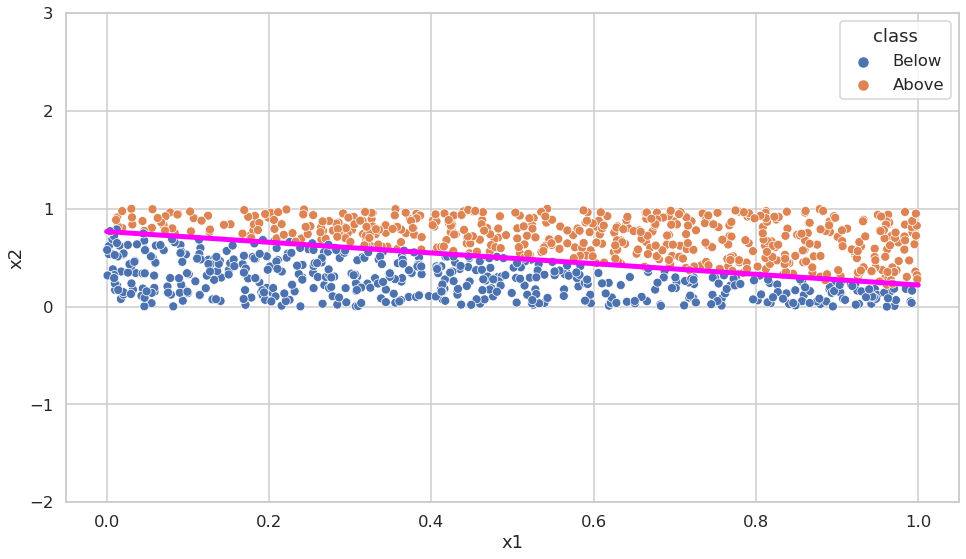

In [7]:
fig, ax = plt.subplots(figsize=(16, 9))

ax = sns.scatterplot(data=df, x="x1", y="x2", hue="class", ax=ax)

w1, w2 = w

x_line = torch.tensor([0, 1])
y_line = ((-w1 * x_line - b) / w2).detach().numpy()

(ln,) = ax.plot(x_line, y_line, color="fuchsia", linewidth=5)
ax.set_ylim((-2, 3))


def set_frame_data(i):
    y_line = ((-ws[i][0] * x_line - bs[i]) / ws[i][1]).detach().numpy()
    ln.set_data(x_line, y_line)
    return (ln,)


anim = FuncAnimation(fig, set_frame_data, frames=len(ws))

In [8]:
HTML(anim.to_jshtml())

1. with and without $b$
2. what if we change the loss function?
3. what if we change the activation function?

# Single Neuron With Auto-differentiation

Copy code from above with the following changes:

1. Add `requires_grad=True` to `w` and `b`
2. Change backprop to auto
    - `w.grad` and `b.grad` to None
    - compute loss
    - call `.backward()`

In [9]:
loss_function = bce_loss

# Parameters
w = torch.randn(nx, 1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

ws = [w.clone()]
bs = [b.clone()]

# Hyper-parameters
learning_rate = 10
num_epochs = 100

# Formatting parameters
print_step = 5
prev_accuracy = 0

for epoch in range(num_epochs):

    # Forward propagation
    Yhat = torch.sigmoid(X_train @ w + b)

    # Backpropagation
    w.grad = None
    b.grad = None
    losses = bce_loss(Yhat, Y_train)
    loss = losses.mean()
    loss.backward()

    # Update parameters
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad

    # Compute and print metrics
    if epoch % print_step == 0:

        Yhat_valid = torch.sigmoid(X_valid @ w + b)
        accuracy = 1 - (Yhat_valid - Y_valid).abs().round().mean()
        e = f"{epoch:>4}/{num_epochs}"
        c = f"{loss:0.2f}"
        a = f"{accuracy:0.2f}"
        print(f"{e}: Loss={c}, Accuracy={a}")

        if accuracy > prev_accuracy:
            ws.append(w.clone())
            bs.append(b.clone())
            prev_accuracy = accuracy

Yhat_valid = torch.sigmoid(X_valid @ w + b)
accuracy = 1 - (Yhat_valid - Y_valid).abs().round().mean()
print(f"Final accuracy: {accuracy:0.2f}")

   0/100: Loss=0.73, Accuracy=0.57
   5/100: Loss=1.71, Accuracy=0.62
  10/100: Loss=0.52, Accuracy=0.64
  15/100: Loss=0.34, Accuracy=0.83
  20/100: Loss=0.22, Accuracy=0.94
  25/100: Loss=0.19, Accuracy=0.98
  30/100: Loss=0.18, Accuracy=0.98
  35/100: Loss=0.18, Accuracy=0.98
  40/100: Loss=0.17, Accuracy=0.99
  45/100: Loss=0.16, Accuracy=0.99
  50/100: Loss=0.16, Accuracy=0.99
  55/100: Loss=0.15, Accuracy=0.99
  60/100: Loss=0.15, Accuracy=0.99
  65/100: Loss=0.15, Accuracy=0.99
  70/100: Loss=0.14, Accuracy=0.99
  75/100: Loss=0.14, Accuracy=0.99
  80/100: Loss=0.14, Accuracy=0.99
  85/100: Loss=0.13, Accuracy=0.99
  90/100: Loss=0.13, Accuracy=0.99
  95/100: Loss=0.13, Accuracy=0.99
Final accuracy: 0.99


Now what if I want to change the loss function or activation function?

In [10]:
def mse_loss(yhat, y):
    return (yhat - y).pow(2)

# Non-linearly Separable Data

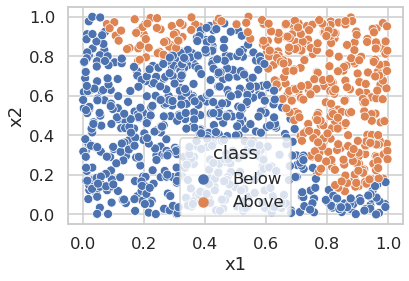

In [11]:
Y = torch.zeros(N, 1)
noise = 0.25 * torch.sin(x1 * 3 * pi)
Y[x2 + x1 - 1.2 + noise > 0] = 1

classes = ["Above" if target == 1 else "Below" for target in Y]
df = pd.DataFrame({"x1": x1, "x2": x2, "class": classes})
ax = sns.scatterplot(data=df, x="x1", y="x2", hue="class")

N_valid = int(N * 0.2)
X_valid = X[:N_valid, :]
Y_valid = Y[:N_valid, :]

X_train = X[N_valid:, :]
Y_train = Y[N_valid:, :]

# Now rerun Neuron cell
# Then rerun plotting and animation cells

# Neural Network

In [12]:
# layer_sizes = (nx, 1)
layer_sizes = (nx, 50, 50, 50, 1)

layers_except_last = [
    torch.nn.Sequential(torch.nn.Linear(nlminus1, nl), torch.nn.ReLU())
    for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes)
]
last_layer = torch.nn.Sequential(torch.nn.Linear(layer_sizes[-2], layer_sizes[-1]), torch.nn.Sigmoid())
net = torch.nn.Sequential(*(layers_except_last + [last_layer]))

print(net)

loss_function = torch.nn.BCELoss()

learning_rate = 0.1
num_epochs = 1000
print_step = 50
prev_accuracy = 0

for epoch in range(num_epochs):

    # Forward propagation
    Yhat = net(X_train)

    # Backpropagation
    net.zero_grad()
    losses = bce_loss(Yhat, Y_train)
    loss = losses.mean()
    loss.backward()

    # Update parameters
    with torch.no_grad():
        for param in net.parameters():
            param -= learning_rate * param.grad

    # Compute and print metrics
    if epoch % print_step == 0:

        with torch.no_grad():
            Yhat_valid = net(X_valid)

        accuracy = 1 - (Yhat_valid - Y_valid).abs().round().mean()
        e = f"{epoch:>4}/{num_epochs}"
        c = f"{loss:0.2f}"
        a = f"{accuracy:0.2f}"
        print(f"{e}: Loss={c}, Accuracy={a}")

        if accuracy > prev_accuracy:
            ws.append(w.clone())
            bs.append(b.clone())
            prev_accuracy = accuracy

with torch.no_grad():
    Yhat_valid = net(X_valid)
accuracy = 1 - (Yhat_valid - Y_valid).abs().round().mean()
print(f"Final accuracy: {accuracy:0.2f}")

Sequential(
  (0): Sequential(
    (0): Linear(in_features=2, out_features=50, bias=True)
    (1): ReLU()
  )
  (1): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): ReLU()
  )
  (2): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): ReLU()
  )
  (3): Sequential(
    (0): Linear(in_features=50, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
   0/1000: Loss=0.71, Accuracy=0.33
  50/1000: Loss=0.65, Accuracy=0.67
 100/1000: Loss=0.62, Accuracy=0.67
 150/1000: Loss=0.53, Accuracy=0.77
 200/1000: Loss=0.35, Accuracy=0.91
 250/1000: Loss=0.28, Accuracy=0.90
 300/1000: Loss=0.26, Accuracy=0.92
 350/1000: Loss=0.25, Accuracy=0.93
 400/1000: Loss=0.24, Accuracy=0.93
 450/1000: Loss=0.24, Accuracy=0.89
 500/1000: Loss=0.24, Accuracy=0.89
 550/1000: Loss=0.23, Accuracy=0.89
 600/1000: Loss=0.22, Accuracy=0.89
 650/1000: Loss=0.21, Accuracy=0.90
 700/1000: Loss=0.21, Accuracy=0.91
 750/1000: Loss=0.20, Accuracy=0.92
 800/1000: Lo

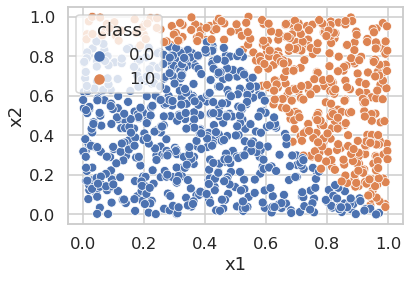

In [13]:
# classes = ["Above" if target == 1 else "Below" for target in Y]
Yhat_all = net(X)
predictions = Yhat_all.squeeze().round().detach().numpy()
df = pd.DataFrame({"x1": X[:,0], "x2": X[:,1], "class": predictions})
ax = sns.scatterplot(data=df, x="x1", y="x2", hue="class")